In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from scipy.stats import randint
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix, roc_curve, classification_report,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, log_loss, brier_score_loss,
    mean_squared_error, mean_absolute_error, r2_score,
    explained_variance_score, max_error, mean_absolute_percentage_error,
    matthews_corrcoef, cohen_kappa_score, jaccard_score, hamming_loss, make_scorer
)
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
import lightgbm as lgb
from timeit import default_timer as timer
from tabulate import tabulate
from joblib import parallel_backend

In [30]:
# Read data
digit_train = pd.read_csv("C:/Users/tyler/Documents/ML Projects (Python)/Projects/Data/digit_train.csv")

digit_train = pd.DataFrame(digit_train)

# Preprocess data
digit_train.columns = digit_train.columns.str.lower()
digit_train['label'] = digit_train['label'].astype('category')

digit_train.head(10)

,id,label,x2,x3,x4,x5,x6,x7,x8,x9,...,x776,x777,x778,x779,x780,x781,x782,x783,x784,x785
0,digit_20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,digit_30,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,digit_50,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,digit_60,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,digit_70,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,digit_80,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,digit_90,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,digit_100,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,digit_110,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,digit_120,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Scale data
scaler = StandardScaler()
digit_train_scaled = digit_train.copy()
numeric_columns = digit_train.select_dtypes(include=np.number).columns

digit_train_scaled[numeric_columns] = scaler.fit_transform(digit_train[numeric_columns])

digit_train_scaled = digit_train_scaled.drop(columns=['id'])

print(digit_train_scaled.head())

  label   x2   x3   x4   x5   x6   x7   x8   x9  x10  ...      x776      x777  \
0     0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.033955 -0.023342   
1     4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.033955 -0.023342   
2     9  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.033955 -0.023342   
3     2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.033955 -0.023342   
4     1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.033955 -0.023342   

       x778      x779      x780      x781  x782  x783  x784  x785  
0 -0.016682 -0.010313 -0.008737 -0.006334   0.0   0.0   0.0   0.0  
1 -0.016682 -0.010313 -0.008737 -0.006334   0.0   0.0   0.0   0.0  
2 -0.016682 -0.010313 -0.008737 -0.006334   0.0   0.0   0.0   0.0  
3 -0.016682 -0.010313 -0.008737 -0.006334   0.0   0.0   0.0   0.0  
4 -0.016682 -0.010313 -0.008737 -0.006334   0.0   0.0   0.0   0.0  

[5 rows x 785 columns]


In [7]:
## UDF to pull search results
def search_results(search_object, top_n=None):
    # Get the results DataFrame
    results = pd.DataFrame(search_object.cv_results_)
    
    # Remove rows with NaN mean_test_score
    results = results.dropna(subset=['mean_test_score'])
    
    # Sort by mean_test_score in descending order
    results = results.sort_values('mean_test_score', ascending=False)
    
    # Add a new 'rank' column
    results['rank'] = range(1, len(results) + 1)
    
    # Select the top N results (or all if top_n is None)
    if top_n is not None:
        top_results = results.head(top_n)
    else:
        top_results = results
    
    # Get the best parameters
    if hasattr(search_object, 'best_params_'):
        best_params = search_object.best_params_
    else:
        best_params = search_object.best_estimator_.get_params()
    
    param_names = [param.replace('classifier__', '') for param in best_params.keys()]
    
    # Create a new df with desired columns
    chart_data = pd.DataFrame()
    chart_data['rank'] = top_results['rank']
    chart_data['target'] = top_results['mean_test_score'].round(4)
    
    # Add columns for each parameter, removing 'classifier__' prefix
    for param in best_params.keys():
        clean_param = param.replace('classifier__', '')
        chart_data[clean_param] = top_results['params'].apply(lambda x: x[param])
    
    # Convert to a list of lists for tabulate
    table_data = chart_data.values.tolist()
    
    # Create headers
    headers = ['rank', 'target'] + param_names
    
    # Create the table
    table = tabulate(table_data, headers=headers, tablefmt='pipe', floatfmt='.4f')
    
    # Add the best result information, removing 'classifier__' prefix
    best_params_str = '; '.join([f"{k.replace('classifier__', '')}={v}" for k, v in best_params.items()])
    best_score = search_object.best_score_
    table += f"\nBest result: {{{best_params_str}}}; f(x) = {best_score:.4f}."
    
    # Add information about failed iterations
    total_iters = len(search_object.cv_results_['mean_test_score'])
    failed_iters = np.isnan(search_object.cv_results_['mean_test_score']).sum()
    if failed_iters > 0:
        table += f"\nNote: {failed_iters} out of {total_iters} iterations failed to produce valid results."
    
    return table

In [8]:
# Heatmap plotting function
def plot_heatmap(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [9]:
def evaluate_model(best_model, X_test, y_test):
    """
    Evaluate the model for multi-class classification using various metrics.
    
    :param best_model: Trained model (from BayesSearchCV or similar)
    :param X_test: Test features
    :param y_test: True labels
    :return: Dictionary of all metrics
    """
    # Make predictions
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)
    
    metrics = {}
    
    # Classification metrics
    metrics['Accuracy'] = accuracy_score(y_test, y_pred)
    metrics['Precision'] = precision_score(y_test, y_pred, average='weighted')
    metrics['Recall'] = recall_score(y_test, y_pred, average='weighted')
    metrics['F1 Score'] = f1_score(y_test, y_pred, average='weighted')
    metrics['Log Loss'] = log_loss(y_test, y_prob)
    metrics['Matthews Correlation Coefficient'] = matthews_corrcoef(y_test, y_pred)
    metrics['Cohen\'s Kappa'] = cohen_kappa_score(y_test, y_pred)
    metrics['Jaccard Score'] = jaccard_score(y_test, y_pred, average='weighted')
    metrics['Hamming Loss'] = hamming_loss(y_test, y_pred)    
    metrics['ROC AUC'] = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
    
    # Using the highest probability as prediction
    y_prob_max = np.max(y_prob, axis=1)
    y_test_binary = (y_test == np.argmax(y_prob, axis=1)).astype(int)

    metrics['Mean Squared Error'] = mean_squared_error(y_test_binary, y_prob_max)
    metrics['Root Mean Squared Error'] = np.sqrt(metrics['Mean Squared Error'])
    metrics['Mean Absolute Error'] = mean_absolute_error(y_test_binary, y_prob_max)
    metrics['R-squared'] = r2_score(y_test_binary, y_prob_max)
    metrics['Explained Variance Score'] = explained_variance_score(y_test_binary, y_prob_max)
    metrics['Max Error'] = max_error(y_test_binary, y_prob_max)    
    metrics['Mean Bias Error'] = np.mean(y_prob_max - y_test_binary)
    metrics['Median Absolute Error'] = np.median(np.abs(y_prob_max - y_test_binary))
    
    # Per-class metrics
    n_classes = len(np.unique(y_test))
    for i in range(n_classes):
        metrics[f'Class {i} Precision'] = precision_score(y_test, y_pred, average=None)[i]
        metrics[f'Class {i} Recall'] = recall_score(y_test, y_pred, average=None)[i]
        metrics[f'Class {i} F1 Score'] = f1_score(y_test, y_pred, average=None)[i]
    
    return metrics

In [10]:
seed = np.random.seed(1000)

X = digit_train_scaled.drop('label', axis=1)
y = digit_train_scaled['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

print(f"Train PCT : {len(X_train) / len(X) * 100:.1f}%")
print(f"Test PCT : {len(X_test) / len(X) * 100:.1f}%")
print(f"Kfold Count: {kfold.get_n_splits()}")

Train PCT : 70.0%
Test PCT : 30.0%
Kfold Count: 3


Parameter Space:
hidden_layer_sizes: Integer(low=10, high=50, prior='uniform', transform='identity')
activation: Categorical(categories=('tanh', 'relu'), prior=None)
solver: Categorical(categories=('sgd', 'adam'), prior=None)
alpha: Real(low=0.0001, high=0.05, prior='log-uniform', transform='identity')
learning_rate: Categorical(categories=('constant', 'adaptive'), prior=None)
learning_rate_init: Real(low=0.01, high=0.6, prior='log-uniform', transform='identity')
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameters: OrderedDict({'activation': 'relu', 'alpha': 0.0005031650447414145, 'hidden_layer_sizes': 43, 'learning_rate': 'adaptive', 'learning_rate_init': 0.07116000122512733, 'solver': 'sgd'})
Best ROC AUC score: 0.997

Top 10 re

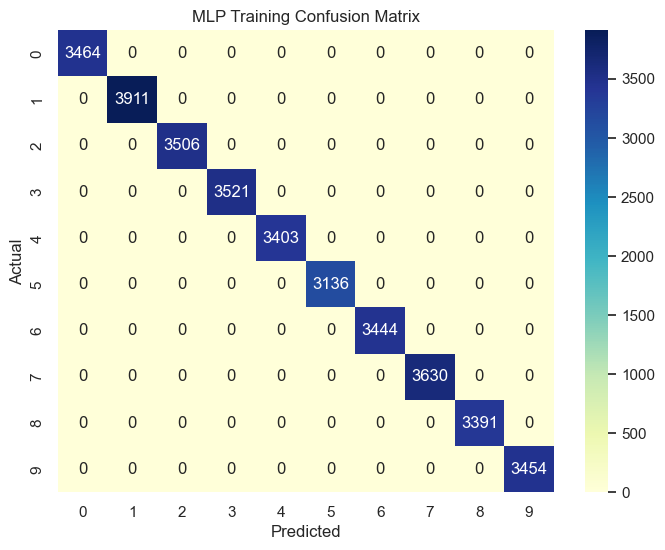

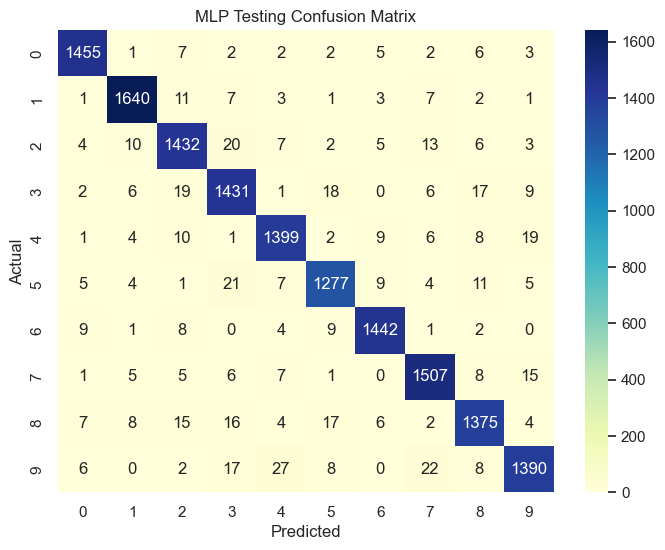

                                         Value
Accuracy                          9.603748e-01
Class 0 F1 Score                  9.778226e-01
Class 0 Precision                 9.758551e-01
Class 0 Recall                    9.797980e-01
Class 1 F1 Score                  9.776453e-01
Class 1 Precision                 9.767719e-01
Class 1 Recall                    9.785203e-01
Class 2 F1 Score                  9.508632e-01
Class 2 Precision                 9.483444e-01
Class 2 Recall                    9.533955e-01
Class 3 F1 Score                  9.445545e-01
Class 3 Precision                 9.408284e-01
Class 3 Recall                    9.483101e-01
Class 4 F1 Score                  9.582192e-01
Class 4 Precision                 9.575633e-01
Class 4 Recall                    9.588759e-01
Class 5 F1 Score                  9.526296e-01
Class 5 Precision                 9.551234e-01
Class 5 Recall                    9.501488e-01
Class 6 F1 Score                  9.759729e-01
Class 6 Preci

In [11]:
# MLP Model
mlp_model = MLPClassifier(max_iter=500)

mlp_param_space = {
    'hidden_layer_sizes': Integer(10,50),
    'activation': Categorical(['tanh', 'relu']),
    'solver': Categorical(['sgd', 'adam']),
    'alpha': Real(0.0001, 0.05, prior='log-uniform'), #[0.0001, 0.05],
    'learning_rate': Categorical(['constant','adaptive']),
    'learning_rate_init': Real(0.01, 0.6, prior='log-uniform') #[0.001, 0.01, 0.1]
}

print("Parameter Space:")
for param, space in mlp_param_space.items():
    print(f"{param}: {space}")

with parallel_backend('threading', n_jobs=-1):
    bayes_search_MLP = BayesSearchCV(
        mlp_model,
        mlp_param_space,
        n_iter=5,
        cv=kfold,
        scoring = make_scorer(
                    roc_auc_score,
                    response_method='predict_proba',  # This replaces needs_proba=True
                    multi_class='ovr',
                    average='weighted'
                    ), 
        error_score='raise',
        n_jobs=-1,
        random_state=seed,
        verbose=1
    )
    
    bayes_search_MLP.fit(X_train, y_train)
    bayes_search_MLP

print("\nBest parameters:", bayes_search_MLP.best_params_)
print("Best ROC AUC score:", round(bayes_search_MLP.best_score_, 3))

results = pd.DataFrame(bayes_search_MLP.cv_results_)
results = results.sort_values('rank_test_score')
print("\nTop 10 results:")
print(results[['params', 'mean_test_score', 'std_test_score']].head(10).round(3))

# Best Model
best_model_MLP_bo = bayes_search_MLP.best_estimator_

# Predictions
y_pred_proba = best_model_MLP_bo.predict_proba(X_test)
test_roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
print(f"\nTest set ROC AUC: {test_roc_auc:.3f}")
print(search_results(bayes_search_MLP))  

# Evaluate MLP
print("MLP Model Evaluation")
plot_heatmap(y_train, best_model_MLP_bo.predict(X_train), "MLP Training Confusion Matrix")
plot_heatmap(y_test, best_model_MLP_bo.predict(X_test), "MLP Testing Confusion Matrix")

MLP_metrics = evaluate_model(best_model_MLP_bo, X_test, y_test)
MLP_metrics_df = pd.DataFrame.from_dict(MLP_metrics, orient='index', columns=['Value'])

# Sort metrics by name
print(MLP_metrics_df.sort_index())

Parameter Space:
n_estimators: Integer(low=100, high=1000, prior='uniform', transform='identity')
min_samples_leaf: Integer(low=1, high=20, prior='uniform', transform='identity')
min_samples_split: Integer(low=2, high=40, prior='uniform', transform='identity')
max_depth: Integer(low=1, high=100, prior='uniform', transform='identity')
min_weight_fraction_leaf: Real(low=0.0, high=0.5, prior='uniform', transform='identity')
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameters: OrderedDict({'max_depth': 99, 'min_samples_leaf': 8, 'min_samples_split': 39, 'min_weight_fraction_leaf': 0.04527383589882417, 'n_estimators': 550})
Best ROC AUC score: 0.978

Top 10 results:
                                              params  mean_test_score 

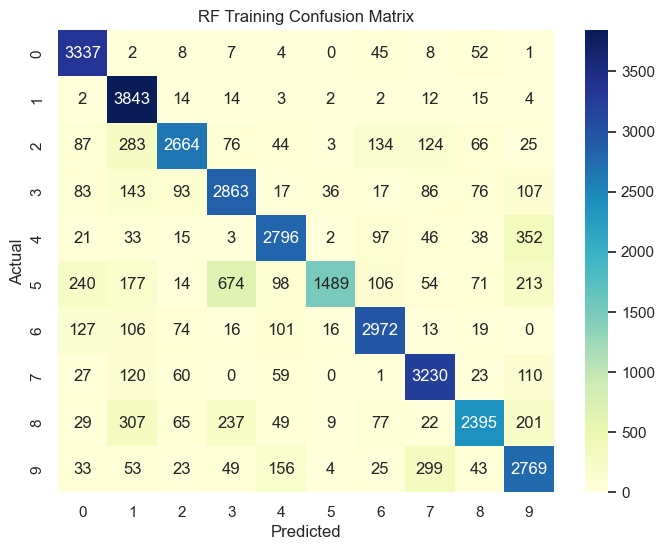

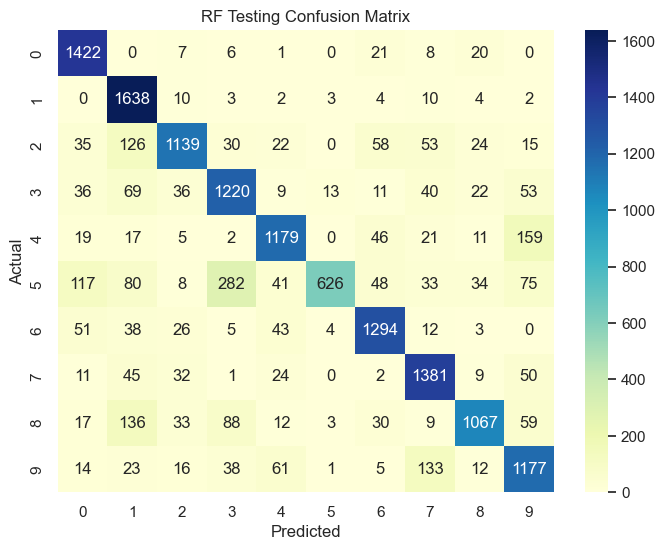

                                     Value
Accuracy                          0.812784
Class 0 F1 Score                  0.886810
Class 0 Precision                 0.825784
Class 0 Recall                    0.957576
Class 1 F1 Score                  0.851351
Class 1 Precision                 0.754144
Class 1 Recall                    0.977327
Class 2 F1 Score                  0.809524
Class 2 Precision                 0.868140
Class 2 Recall                    0.758322
Class 3 F1 Score                  0.766332
Class 3 Precision                 0.728358
Class 3 Recall                    0.808482
Class 4 F1 Score                  0.826498
Class 4 Precision                 0.845768
Class 4 Recall                    0.808088
Class 5 F1 Score                  0.627884
Class 5 Precision                 0.963077
Class 5 Recall                    0.465774
Class 6 F1 Score                  0.864107
Class 6 Precision                 0.851876
Class 6 Recall                    0.876694
Class 7 F1 

In [12]:
# Random Forest Model
rf_model = RandomForestClassifier(random_state=seed)

# Define parameter distributions for random search
rf_param_space = {
    'n_estimators': Integer(100, 1000),  # equivalent to trees() in R
    'min_samples_leaf': Integer(1, 20),  # equivalent to min_n() in R
    'min_samples_split': Integer(2, 40),
    'max_depth': Integer(1, 100),
    'min_weight_fraction_leaf': Real(0.0, 0.5)
}

# Print parameter space
print("Parameter Space:")
for param, space in rf_param_space.items():
    print(f"{param}: {space}")

### Perform Bayesian optimization ###
with parallel_backend('threading', n_jobs=-1):
    bayes_search_RF = BayesSearchCV(
        rf_model,
        rf_param_space,
        n_iter=5,  # number of parameter settings that are sampled
        cv=kfold,
        scoring = make_scorer( #multi_class_roc_auc_scorer, #'roc_auc',
                    roc_auc_score,
                    response_method='predict_proba',  # This replaces needs_proba=True
                    multi_class='ovr',
                    average='weighted'
                    ),
        error_score='raise',
        n_jobs=-1,
        random_state=seed,
        verbose=1
    )
    
    # Fit to training dat
    bayes_search_RF.fit(X_train, y_train)
    bayes_search_RF

# Print results
print("\nBest parameters:", bayes_search_RF.best_params_)
print("Best ROC AUC score:", round(bayes_search_RF.best_score_, 3))

# Results
results = pd.DataFrame(bayes_search_RF.cv_results_)
results = results.sort_values('rank_test_score')
print("\nTop 10 results:")
print(results[['params', 'mean_test_score', 'std_test_score']].head(10).round(3))

# Best Model
best_model_RF_bo = bayes_search_RF.best_estimator_
best_model_RF_bo

# Test Predictions
y_pred_proba = best_model_RF_bo.predict_proba(X_test)
test_roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
print(f"\nTest set ROC AUC: {test_roc_auc:.3f}")
print(search_results(bayes_search_RF))  

# Evaluate XGBoost
print("Random Forest Model Evaluation")
plot_heatmap(y_train, best_model_RF_bo.predict(X_train), "RF Training Confusion Matrix")
plot_heatmap(y_test, best_model_RF_bo.predict(X_test), "RF Testing Confusion Matrix")

RF_metrics = evaluate_model(best_model_RF_bo, X_test, y_test)
RF_metrics_df = pd.DataFrame.from_dict(RF_metrics, orient='index', columns=['Value'])

# Sort metrics by name
print(RF_metrics_df.sort_index())

Parameter Space:
n_estimators: Integer(low=100, high=1000, prior='uniform', transform='identity')
max_depth: Integer(low=1, high=40, prior='uniform', transform='identity')
min_child_weight: Integer(low=1, high=20, prior='uniform', transform='identity')
gamma: Integer(low=0, high=10, prior='uniform', transform='identity')
learning_rate: Real(low=0.01, high=1.0, prior='log-uniform', transform='identity')
reg_alpha: Integer(low=0, high=10, prior='uniform', transform='identity')
reg_lambda: Integer(low=0, high=10, prior='uniform', transform='identity')
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameters: OrderedDict({'gamma': 0, 'learning_rate': 0.6165839456671516, 'max_depth': 13, 'min_child_weight': 17, 'n_estimators': 189, 'reg_alp

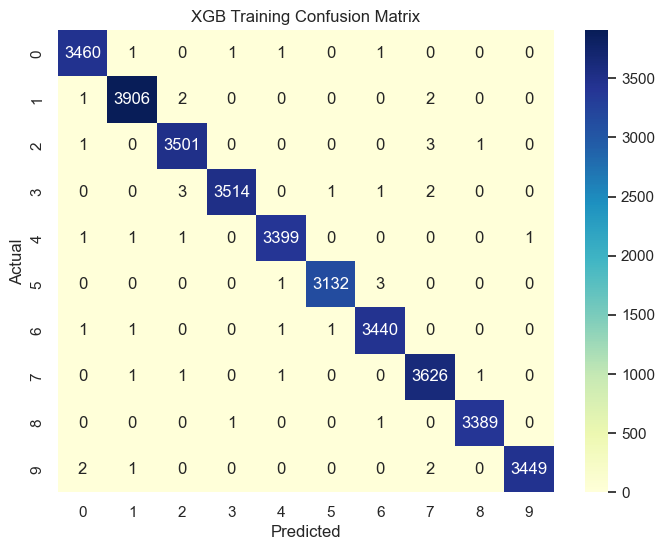

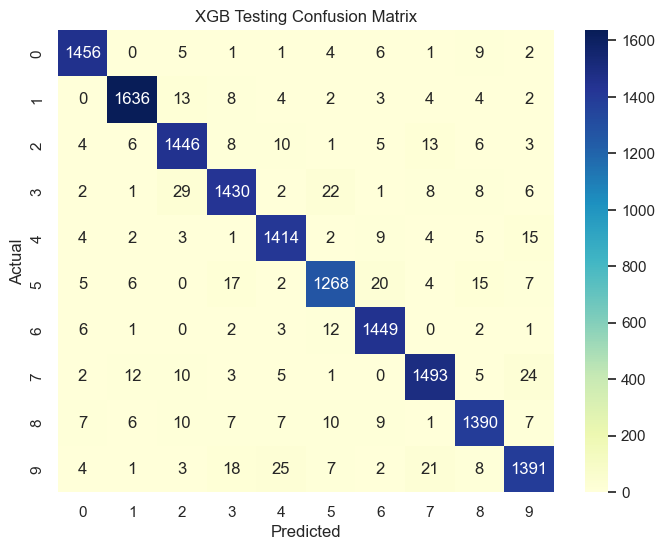

                                     Value
Accuracy                          0.962048
Class 0 F1 Score                  0.978824
Class 0 Precision                 0.977181
Class 0 Recall                    0.980471
Class 1 F1 Score                  0.977592
Class 1 Precision                 0.979054
Class 1 Recall                    0.976134
Class 2 F1 Score                  0.957299
Class 2 Precision                 0.951942
Class 2 Recall                    0.962716
Class 3 F1 Score                  0.952064
Class 3 Precision                 0.956522
Class 3 Recall                    0.947647
Class 4 F1 Score                  0.964529
Class 4 Precision                 0.959946
Class 4 Recall                    0.969157
Class 5 F1 Score                  0.948747
Class 5 Precision                 0.954101
Class 5 Recall                    0.943452
Class 6 F1 Score                  0.972483
Class 6 Precision                 0.963431
Class 6 Recall                    0.981707
Class 7 F1 

In [13]:
### Bayesian Optimization of Hyperparameter Tuning for XGBoost ###

xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=seed)

# Parameter space
xgb_param_space = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(1, 40),
    'min_child_weight': Integer(1, 20),
    'gamma': Integer(0, 10),
    'learning_rate': Real(0.01, 1.0, prior='log-uniform'),
    #'max_delta_step': Integer(,),
    #'subsample': Real(0.5, 1.0),
    #'colsample_bytree': Real(0.5, 1.0),
    #'colsample_bylevel': Real(0.5, 1.0),
    'reg_alpha': Integer(0, 10),
    'reg_lambda': Integer(0, 10)
}

print("Parameter Space:")
for param, space in xgb_param_space.items():
    print(f"{param}: {space}")

with parallel_backend('threading', n_jobs=-1):
    # Perform Bayesian optimization
    bayes_search_XGB = BayesSearchCV(
        xgb_model,
        xgb_param_space,
        n_iter=5, 
        cv=kfold,
        scoring = make_scorer(
                    roc_auc_score,
                    response_method='predict_proba',  # This replaces needs_proba=True
                    multi_class='ovr',
                    average='weighted'
                    ),
        error_score='raise',
        n_jobs=-1,
        random_state=seed,
        verbose=1
    )
    
    # Fit to training dat
    bayes_search_XGB.fit(X_train, y_train)
    bayes_search_XGB

# Print results
print("\nBest parameters:", bayes_search_XGB.best_params_)
print("Best ROC AUC score:", round(bayes_search_XGB.best_score_, 3))

# Results
results = pd.DataFrame(bayes_search_XGB.cv_results_)
results = results.sort_values('rank_test_score')
print("\nTop 10 results:")
print(results[['params', 'mean_test_score', 'std_test_score']].head(10).round(3))

# Best Model
best_model_XGB_bo = bayes_search_XGB.best_estimator_
best_model_XGB_bo

# Test Predictions
y_pred_proba = best_model_XGB_bo.predict_proba(X_test)
test_roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
print(f"\nTest set ROC AUC: {test_roc_auc:.3f}")
print(search_results(bayes_search_XGB))  

# Evaluate XGBoost
print("XGBoost Model Evaluation")
plot_heatmap(y_train, best_model_XGB_bo.predict(X_train), "XGB Training Confusion Matrix")
plot_heatmap(y_test, best_model_XGB_bo.predict(X_test), "XGB Testing Confusion Matrix")

metrics = evaluate_model(best_model_XGB_bo, X_test, y_test)
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])

# Sort the metrics by name
print(metrics_df.sort_index())